### ICVL

In [38]:
root = '/home/wuyiming/git/Hand'
caffe_root = root + '/caffe'
import sys
sys.path.insert(0, caffe_root + '/python')
sys.path.insert(0, 'lib')
sys.path.insert(0, 'lib/data_layer/')
sys.path.insert(0, 'lib/data/')
sys.path.insert(0, 'lib/util/')

import caffe

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py
from matplotlib.patches import Circle
import scipy.io as scio
import os
import time

In [136]:
fx = 241.42
fy = 241.42
ux = 160
uy = 120
def jointsImgTo3D(sample):
    """
    Normalize sample to metric 3D
    :param sample: joints in (x,y,z) with x,y in image coordinates and z in mm
    :return: normalized joints in mm
    """
    ret = np.zeros((sample.shape[0], 3), np.float32)
    for i in range(sample.shape[0]):
        ret[i] = jointImgTo3D(sample[i])
    return ret

def jointImgTo3D(sample):
    """
    Normalize sample to metric 3D
    :param sample: joints in (x,y,z) with x,y in image coordinates and z in mm
    :return: normalized joints in mm
    """
    ret = np.zeros((3,), np.float32)
    # convert to metric using f, see Thomson et al.
    ret[0] = (sample[0] - ux) * sample[2] / fx
    ret[1] = (sample[1] - uy) * sample[2] / fy
    ret[2] = sample[2]
    return ret

def loadPredFile(filepath):
    import os
    assert os.path.isfile(filepath), "{} is not exists or is not a file!".format(filepath)
    with open(filepath, 'r') as f:
        lines = f.readlines()
        for index, line in enumerate(lines):
            lines[index] = map(float, line.split())
        joints = np.array(lines)
        print joints.shape
        n, d = joints.shape
        return joints.reshape(n, d/3, 3)
    
def getNumFrameWithinMaxDist(gt, joints, dist):
    return (np.nanmax(np.sqrt(np.square(gt - joints).sum(axis=2)), axis=1) <= dist).sum()

def plotAccuracy(gt, joints, thresh = 80, label='ours'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot([getNumFrameWithinMaxDist(gt, joints, j)/ float(joints.shape[0]) * 100. for j in range(0, 80)], label=label)
    ax.grid(True)
    plt.xlabel('Distance threshold / mm')
    plt.ylabel('Fraction of frames within threshold / %')
    plt.xlim((0, 80))
    plt.ylim((0.0, 100.0))

def predict_joints(model_name, weights_num):
    """predict joints"""
    model_def = 'models/ICVL/hand_' + model_name + '/hand_' + model_name + '.prototxt'
    model_weights = 'weights/ICVL/hand_' + model_name + '/hand_' + model_name + '_iter_' + weights_num + '.caffemodel'

    print model_def
    print model_weights
    
    net = caffe.Net(model_def,
                   model_weights,
                   caffe.TEST)
    
    file_name = 'result/OURS/ICVL/hand_' + model_name + '_' + weights_num + '.txt'
    
    import os
    if os.path.isfile(file_name):
        return file_name
    
    print file_name
    
    t_start = time.time()

    predicted_joints = np.array([None]* 702)
    
    if model_name == 'baseline':
        frame_size, joint_size, = net.blobs['joint_pred'].data.shape
        seq_size = 1
    else:
        frame_size, seq_size, joint_size = net.blobs['pred_joint'].data.shape
    dim = 3
    
    for i in xrange(np.int(np.ceil(702./ (frame_size * seq_size)))):
        net.forward()
        print 'test iter = ', i
        for j, ind in enumerate(net.blobs['inds'].data):
            row = j / seq_size
            col = j % seq_size
            if predicted_joints[int(ind)] == None:
                predicted_joints[int(ind)] = (net.blobs['pred_joint'].data[row][col].reshape(16, 3) \
                                              * net.blobs['config'].data[j][0] / 2 \
                                              + net.blobs['com'].data[j].reshape(1, 3)).copy()
    t_end = time.time()
    print 'time elapse {}'.format((t_end - t_start) / 702)
    
    with open(file_name, 'w') as f:
        for i in xrange(predicted_joints.shape[0]):
            for item in predicted_joints[i].reshape(16*3):
                f.write("%s "% item)
            f.write("\n")
     
    return file_name

def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)

    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

### test

In [6]:
caffe.set_device(0)
caffe.set_mode_gpu()
net = caffe.Net('./models/ICVL/hand_lstm_small_frame_size/hand_lstm_small_frame_size.prototxt', 
                './weights/ICVL/hand_lstm_small_frame_size/hand_lstm_small_frame_size_iter_200000.caffemodel',
                caffe.TEST)

size of dataset is test1: 702
dataset: ICVL phase: test_1
Outputs:  ['depth', 'joint', 'clip_markers', 'com', 'config', 'inds']


### Read ground truth

In [139]:
gt_file = './dataset/ICVL/test_seq_1.txt'
gt = []
f = open(gt_file, 'r')
lines = f.readlines()
for line in lines:
    gt.append(map(float, line.split(' ')[1:-1]))
gt = np.array(gt)
gt3D = []
for i in xrange(gt.shape[0]):
    gt3D.append(jointsImgTo3D(gt[i].reshape(16, 3)))
gt3D = np.array(gt3D)

In [140]:
gt3D[0]

array([[  30.87788582,   38.85021591,  368.85400391],
       [   6.77187777,   51.50400925,  355.86999512],
       [ -20.13546371,   34.17987442,  354.85101318],
       [ -38.90395737,   18.12351799,  349.55499268],
       [   5.42264652,  -11.51812172,  357.78500366],
       [  -2.93231583,  -37.45681   ,  347.35998535],
       [  -8.47680283,  -55.2942009 ,  343.59799194],
       [  27.84412956,  -15.1800518 ,  363.06399536],
       [  30.44153023,  -48.11777878,  355.29098511],
       [  32.33983612,  -69.76394653,  353.11999512],
       [  45.66884232,   -4.60396385,  365.38101196],
       [  54.80501938,  -33.34441376,  359.79299927],
       [  61.16431046,  -52.92427444,  357.46798706],
       [  63.34932327,   10.08257389,  369.03201294],
       [  79.11164856,   -7.20125055,  367.94198608],
       [  90.86534119,  -20.93623352,  365.125     ]], dtype=float32)

In [138]:
pred_joints[0]

array([[  30.4537 ,   31.5554 ,  367.849  ],
       [   1.78531,   43.6418 ,  353.589  ],
       [ -28.5635 ,   26.7316 ,  353.695  ],
       [ -48.611  ,   11.9366 ,  350.03   ],
       [   2.3439 ,  -21.4219 ,  358.6    ],
       [  -5.56242,  -44.9381 ,  348.304  ],
       [ -10.6416 ,  -57.7374 ,  343.255  ],
       [  27.3949 ,  -23.0857 ,  366.587  ],
       [  31.1486 ,  -54.2314 ,  358.09   ],
       [  34.0692 ,  -71.8086 ,  351.319  ],
       [  46.8118 ,  -12.0764 ,  367.893  ],
       [  54.7152 ,  -41.405  ,  361.893  ],
       [  60.4714 ,  -58.1645 ,  355.642  ],
       [  68.2592 ,    5.5283 ,  370.811  ],
       [  83.914  ,  -10.5339 ,  368.719  ],
       [  95.3923 ,  -19.0521 ,  360.095  ]])

### plot by ourselves

In [39]:
from util.handpose_evaluation import ICVLHandposeEvaluation

models/ICVL/hand_lstm_small_frame_size/hand_lstm_small_frame_size.prototxt
weights/ICVL/hand_lstm_small_frame_size/hand_lstm_small_frame_size_iter_200000.caffemodel
size of dataset is test1: 702
dataset: ICVL phase: test_1
Outputs:  ['depth', 'joint', 'clip_markers', 'com', 'config', 'inds']
(702, 48)


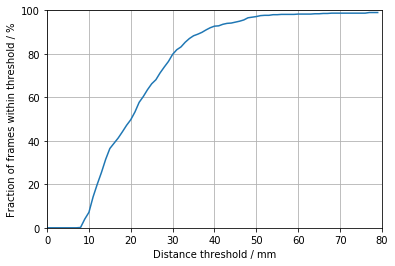

In [141]:
model_num = 'lstm_small_frame_size'
weights_num = '200000'
pred_ours_file = predict_joints(model_num, weights_num)
pred_joints = loadPredFile(pred_ours_file)
plotAccuracy(gt3D, pred_joints, label='ours')